[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MohamedElquesni/ACL-International-Hotel-Booking-Analytics-/blob/Nadine/Milestone%201/Milestone%201.ipynb)

# Milestone 1: International Hotel Booking Analytics
## Predicting Hotel Country Groups using Machine Learning (ML)

**Team Number:** [90]  
---

## Project Overview

**Goal:** Build a multi-class classification model to predict the country group of hotels based on user demographics, hotel characteristics, and review scores.

**Dataset:**
- 50,000 reviews across 25 hotels in 25 countries
- 2,000 unique users with demographic information
- 11 target country groups

**Deliverables:**
1. A cleaned dataset after the feature engineering step.
2. Data engineering insights, including:
 - The best city for each traveller type.
 - The top three countries with the best value-for-money scores per traveller age group.

3. A trained classification model (statistical ML or shallow FFNN).
4. Model interpretation and explainability through XAI techniques (SHAP and LIME).
5. An inference function.

---

# Section 1: Data Cleaning

## 1.1 - Importing Libraries

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

## 1.2 - Loading and Assessing Datasets

### Hotels Dataset

#### Loading the Hotels Dataset


In [6]:
df_hotels = pd.read_csv('../Dataset [Original]/hotels.csv')
df_hotels.head()

,hotel_id,hotel_name,city,country,star_rating,lat,lon,cleanliness_base,comfort_base,facilities_base,location_base,staff_base,value_for_money_base
0,1,The Azure Tower,New York,United States,5,40.7580,-73.9855,9.1,8.8,8.9,9.5,8.6,8.0
1,2,The Royal Compass,London,United Kingdom,5,51.5072,-0.1276,9.0,9.2,8.8,9.4,9.0,7.9
2,3,L'Étoile Palace,Paris,France,5,48.8566,2.3522,8.8,9.4,8.7,9.6,9.3,8.1
3,4,Kyo-to Grand,Tokyo,Japan,5,35.6895,139.6917,9.6,9.0,9.3,8.5,9.5,8.2
4,5,The Golden Oasis,Dubai,United Arab Emirates,5,25.2769,55.2962,9.3,9.5,9.6,8.9,9.4,8.5


#### Renaming Hotel Columns --> Hotel_ + Original Column name

In [7]:
df_hotels.columns = [
    col if col == 'hotel_id' or col == 'hotel_name' else 'hotel_' + col
    for col in df_hotels.columns
]


#### Checking for Null Values

In [8]:
df_hotels.isnull().sum()

hotel_id                      0
hotel_name                    0
hotel_city                    0
hotel_country                 0
hotel_star_rating             0
hotel_lat                     0
hotel_lon                     0
hotel_cleanliness_base        0
hotel_comfort_base            0
hotel_facilities_base         0
hotel_location_base           0
hotel_staff_base              0
hotel_value_for_money_base    0
dtype: int64

#### Checking for Duplicated Values

In [9]:
df_hotels.duplicated().sum()

np.int64(0)

### Reviews Dataset

In [10]:
df_reviews = pd.read_csv('../Dataset [Original]/reviews.csv')
df_reviews.head()

,review_id,user_id,hotel_id,review_date,score_overall,score_cleanliness,score_comfort,score_facilities,score_location,score_staff,score_value_for_money,review_text
0,1,1600,1,2022-10-07,8.7,8.6,8.7,8.5,9.0,8.8,8.7,Practice reduce young our because machine. Rec...
1,2,432,4,2020-03-24,9.1,10.0,9.1,9.0,8.6,9.4,8.6,Test cover traditional black. Process tell Mr ...
2,3,186,18,2023-12-18,8.8,9.7,8.8,8.3,8.7,8.1,8.6,Friend million student social study yeah. Grow...
3,4,1403,19,2022-06-22,8.9,9.0,8.8,8.5,9.6,9.1,8.3,Huge girl already remain truth behind card. Ap...
4,5,1723,17,2022-07-02,9.1,8.9,9.5,9.3,8.3,9.4,8.9,Cover feeling call community serve television ...


#### Renaming Reviews Columns --> Review_ + Original Column name

In [11]:
df_reviews.columns = [
    col if col == 'review_id'
           or col == 'user_id'
           or col == 'hotel_id'
           or col == 'review_date'
           or col == 'review_text'
        else 'review_' + col
    for col in df_reviews.columns
]


#### Checking for Null Values

In [12]:
df_reviews.isnull().sum()

review_id                       0
user_id                         0
hotel_id                        0
review_date                     0
review_score_overall            0
review_score_cleanliness        0
review_score_comfort            0
review_score_facilities         0
review_score_location           0
review_score_staff              0
review_score_value_for_money    0
review_text                     0
dtype: int64

#### Checking for Duplicated Values

In [13]:
df_reviews.duplicated().sum()

np.int64(0)

### Users Dataset

In [14]:
df_users = pd.read_csv('../Dataset [Original]/users.csv')
df_users.head() # This shows the 5 rows

,user_id,user_gender,country,age_group,traveller_type,join_date
0,1,Female,United Kingdom,35-44,Solo,2024-09-29
1,2,Male,United Kingdom,25-34,Solo,2023-11-29
2,3,Female,Mexico,25-34,Family,2022-04-03
3,4,Male,India,35-44,Family,2023-12-02
4,5,Other,Japan,25-34,Solo,2021-12-18


#### Renaming Users Columns --> User_ + Original Column name

In [15]:
df_users.columns = [
    col if col == 'user_id'
        or col == 'user_gender'
        else 'user_' + col
    for col in df_users.columns
]


#### Checking for Null Values

In [16]:
df_users.isnull().sum()

user_id                0
user_gender            0
user_country           0
user_age_group         0
user_traveller_type    0
user_join_date         0
dtype: int64

#### Checking for Duplicated Values

In [17]:
df_users.duplicated().sum()

np.int64(0)

## 1.3 - Merging Datasets

In [18]:
# Merge reviews with users on user_id
df_merged = pd.merge(df_reviews, df_users, on='user_id', how='left')

# Merge the result with hotels on hotel_id
df_merged = pd.merge(df_merged, df_hotels, on='hotel_id', how='left')

df_merged.head()

,review_id,user_id,hotel_id,review_date,review_score_overall,review_score_cleanliness,review_score_comfort,review_score_facilities,review_score_location,review_score_staff,...,hotel_country,hotel_star_rating,hotel_lat,hotel_lon,hotel_cleanliness_base,hotel_comfort_base,hotel_facilities_base,hotel_location_base,hotel_staff_base,hotel_value_for_money_base
0,1,1600,1,2022-10-07,8.7,8.6,8.7,8.5,9.0,8.8,...,United States,5,40.7580,-73.9855,9.1,8.8,8.9,9.5,8.6,8.0
1,2,432,4,2020-03-24,9.1,10.0,9.1,9.0,8.6,9.4,...,Japan,5,35.6895,139.6917,9.6,9.0,9.3,8.5,9.5,8.2
2,3,186,18,2023-12-18,8.8,9.7,8.8,8.3,8.7,8.1,...,Egypt,5,30.0444,31.2357,8.8,8.7,8.6,9.1,8.7,8.4
3,4,1403,19,2022-06-22,8.9,9.0,8.8,8.5,9.6,9.1,...,Spain,5,41.3851,2.1734,9.2,9.1,8.9,9.7,9.0,8.8
4,5,1723,17,2022-07-02,9.1,8.9,9.5,9.3,8.3,9.4,...,Russia,5,55.7558,37.6173,9.1,9.3,9.0,9.0,9.1,8.6


In [19]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   review_id                     50000 non-null  int64  
 1   user_id                       50000 non-null  int64  
 2   hotel_id                      50000 non-null  int64  
 3   review_date                   50000 non-null  object 
 4   review_score_overall          50000 non-null  float64
 5   review_score_cleanliness      50000 non-null  float64
 6   review_score_comfort          50000 non-null  float64
 7   review_score_facilities       50000 non-null  float64
 8   review_score_location         50000 non-null  float64
 9   review_score_staff            50000 non-null  float64
 10  review_score_value_for_money  50000 non-null  float64
 11  review_text                   50000 non-null  object 
 12  user_gender                   50000 non-null  object 
 13  u

## 1.4 - Dropping Unnecessary Columns

In [20]:
# Drop unnecessary columns that do not contribute to the predictive modeling task
# These columns are either textual, identifiers or dates that add no generalizable value

df_merged.drop(
    columns=[
        'review_date',
        'review_text',
        'user_join_date',
        'hotel_name'
    ],
    inplace=True
)

df_merged.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   review_id                     50000 non-null  int64  
 1   user_id                       50000 non-null  int64  
 2   hotel_id                      50000 non-null  int64  
 3   review_score_overall          50000 non-null  float64
 4   review_score_cleanliness      50000 non-null  float64
 5   review_score_comfort          50000 non-null  float64
 6   review_score_facilities       50000 non-null  float64
 7   review_score_location         50000 non-null  float64
 8   review_score_staff            50000 non-null  float64
 9   review_score_value_for_money  50000 non-null  float64
 10  user_gender                   50000 non-null  object 
 11  user_country                  50000 non-null  object 
 12  user_age_group                50000 non-null  object 
 13  u

---

## 1.5 - Cleaned Dataset Summary

All datasets have been successfully loaded, cleaned, and merged:
- No null values found.
- No duplicate records.
- Columns renamed with prefixes for clarity.
- Unnecessary columns were dropped.
- Final merged dataset contains 50,000 reviews with complete hotel characteristics and user information


# Section 2: Data Engineering Questions

Using the cleaned and merged dataset, we analyze and visualize the following:

1. **Best City for Each Trave;ler Type**
   - Identify the city with the highest average review score for each traveler type.

2. **Top 3 Countries by Value-for-Money per Age Group**
   - Find the top 3 countries with the highest value-for-money score per traveller’s age group.

## 2.1 - Best City for Each Traveller Type

### Heatmap Analysis

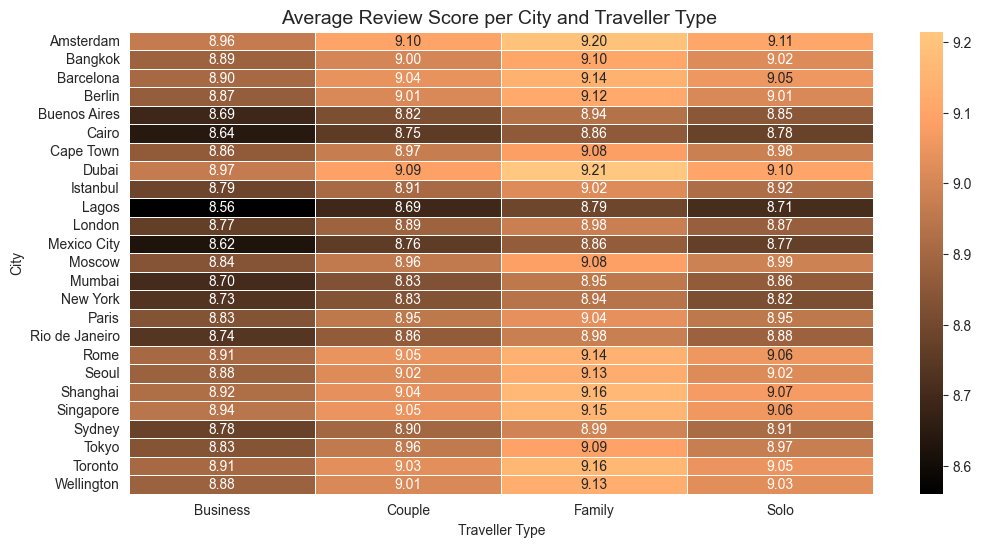

In [21]:
pivot = pd.pivot_table(
        df_merged,
        index="hotel_city",
        columns="user_traveller_type",
        values="review_score_overall",
        aggfunc="mean"
    )

plt.figure(figsize = (12,6))


sns.heatmap(pivot, annot=True, cmap="copper", fmt=".2f", linewidths=0.5)

# Extra GUI enhancements
plt.title("Average Review Score per City and Traveller Type ", fontsize=14)
plt.xlabel("Traveller Type")
plt.ylabel("City")
plt.show()


### Insights

Using the heatmap visualization, we can observe clear differences in average review scores across traveller types and cities:

- **Business travellers:** Dubai achieved the highest average score of **8.97**.
- **Couples:** Amsterdam recorded the highest average score of **9.10**.
- **Families:** Dubai again stood out with an average score of **9.21**.
- **Solo travellers:** Amsterdam had the highest average score of **9.11**.

## 2.2 - Top 3 Countries by Value-for-Money per Age Group

### Heatmap Analysis

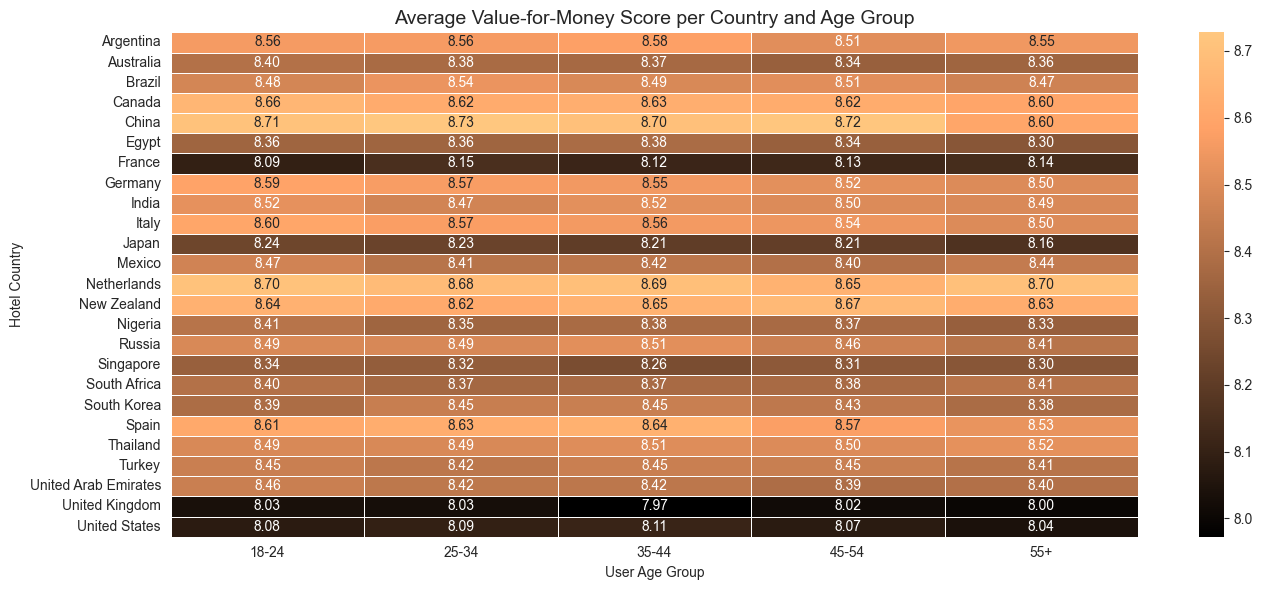

In [22]:
pivot = pd.pivot_table(
    df_merged,
    index="hotel_country",
    columns="user_age_group",
    values="review_score_value_for_money",
    aggfunc="mean"
)

plt.figure(figsize=(14, 6))

sns.heatmap(
    pivot,
    annot=True,
    cmap="copper",
    fmt=".2f",
    linewidths=0.5
)

# Extra GUI Interface
plt.title("Average Value-for-Money Score per Country and Age Group", fontsize=14)
plt.xlabel("User Age Group")
plt.ylabel("Hotel Country")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### Insights

Top 3 countries by value-for-money score for each age group:

- **18–24:** China (8.71), Netherlands (8.70), Canada (8.66)
- **25–34:** China (8.73), Netherlands (8.68), Spain (8.63)
- **35–44:** China (8.70), Netherlands (8.69), New Zealand (8.65)
- **45–54:** China (8.72), New Zealand (8.67), Netherlands (8.65)
- **55+:** Netherlands (8.70), New Zealand (8.63), China (8.60)

---

# Section 3: Exploratory Data Analysis (EDA)

**Objective:** Understand data distributions, correlations, and patterns to inform feature engineering and modeling decisions.

---

## 3.1 - Target Variable Analysis

### Create Target Variable

We group the 25 countries into 11 geographic regions (country groups) to create our classification target.

In [23]:
# Create a mapping dictionary from country names to geographic regions (country groups)
# This groups the 25 countries into 11 regions (country groups) for classification
country_to_group = {
    # North America
    'United States': 'North_America',
    'Canada': 'North_America',

    # Western Europe
    'Germany': 'Western_Europe',
    'France': 'Western_Europe',
    'United Kingdom': 'Western_Europe',
    'Netherlands': 'Western_Europe',
    'Spain': 'Western_Europe',
    'Italy': 'Western_Europe',

    # Eastern Europe
    'Russia': 'Eastern_Europe',

    # East Asia
    'China': 'East_Asia',
    'Japan': 'East_Asia',
    'South Korea': 'East_Asia',

    # Southeast Asia
    'Thailand': 'Southeast_Asia',
    'Singapore': 'Southeast_Asia',

    # Middle East
    'United Arab Emirates': 'Middle_East',
    'Turkey': 'Middle_East',

    # Africa
    'Egypt': 'Africa',
    'Nigeria': 'Africa',
    'South Africa': 'Africa',

    # Oceania
    'Australia': 'Oceania',
    'New Zealand': 'Oceania',

    # South America
    'Brazil': 'South_America',
    'Argentina': 'South_America',

    # South Asia
    'India': 'South_Asia',

    # North America (Mexico separate due to different characteristics)
    'Mexico': 'North_America_Mexico'
}

# Apply the mapping to create our target variable
df_merged['country_group'] = df_merged['hotel_country'].map(country_to_group)

df_merged.head()


,review_id,user_id,hotel_id,review_score_overall,review_score_cleanliness,review_score_comfort,review_score_facilities,review_score_location,review_score_staff,review_score_value_for_money,...,hotel_star_rating,hotel_lat,hotel_lon,hotel_cleanliness_base,hotel_comfort_base,hotel_facilities_base,hotel_location_base,hotel_staff_base,hotel_value_for_money_base,country_group
0,1,1600,1,8.7,8.6,8.7,8.5,9.0,8.8,8.7,...,5,40.7580,-73.9855,9.1,8.8,8.9,9.5,8.6,8.0,North_America
1,2,432,4,9.1,10.0,9.1,9.0,8.6,9.4,8.6,...,5,35.6895,139.6917,9.6,9.0,9.3,8.5,9.5,8.2,East_Asia
2,3,186,18,8.8,9.7,8.8,8.3,8.7,8.1,8.6,...,5,30.0444,31.2357,8.8,8.7,8.6,9.1,8.7,8.4,Africa
3,4,1403,19,8.9,9.0,8.8,8.5,9.6,9.1,8.3,...,5,41.3851,2.1734,9.2,9.1,8.9,9.7,9.0,8.8,Western_Europe
4,5,1723,17,9.1,8.9,9.5,9.3,8.3,9.4,8.9,...,5,55.7558,37.6173,9.1,9.3,9.0,9.0,9.1,8.6,Eastern_Europe


In [24]:
# Count how many reviews belong to each country group
print("Distribution of reviews across country groups:")
print(df_merged['country_group'].value_counts().sort_index())

Distribution of reviews across country groups:
country_group
Africa                   6132
East_Asia                6082
Eastern_Europe           1970
Middle_East              3983
North_America            3962
North_America_Mexico     2004
Oceania                  4014
South_America            3918
South_Asia               1989
Southeast_Asia           4070
Western_Europe          11876
Name: count, dtype: int64


### Visualize Target Distribution

Now let's visualize the distribution to better understand class imbalance.

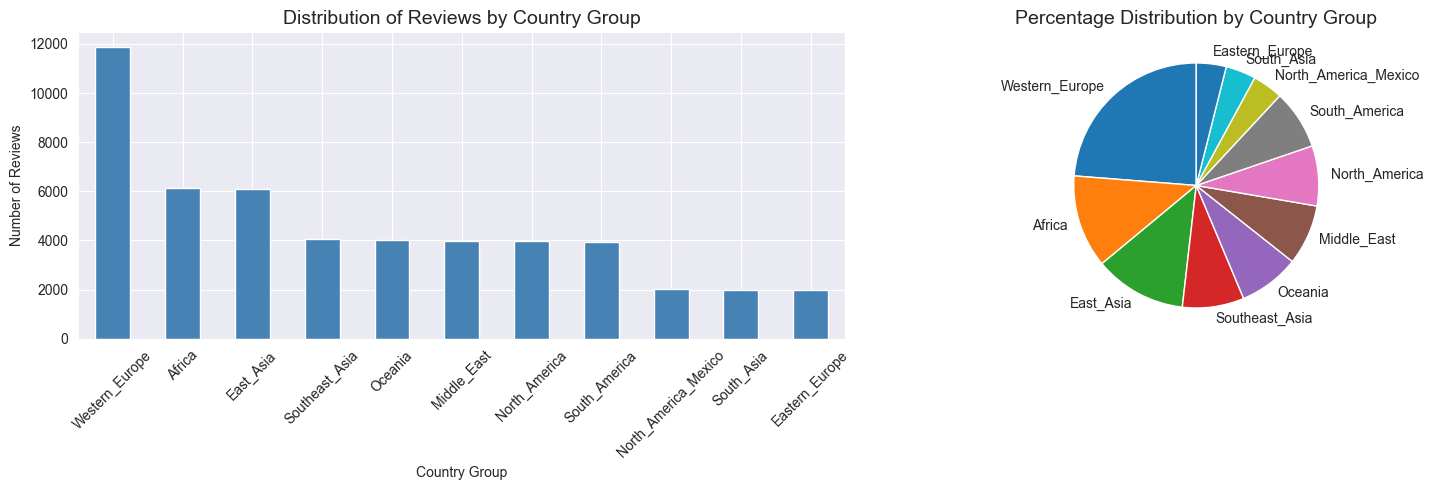


Class Imbalance Analysis:
Largest class: Western_Europe with 11876 samples
Smallest class: Eastern_Europe with 1970 samples
Imbalance ratio: 6.03:1

This means the largest class has 6.03x more samples than the smallest class.


In [25]:
# Get the distribution sorted by count (descending)
target_dist = df_merged['country_group'].value_counts().sort_values(ascending=False)

# Create a figure with 2 subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# First plot: Bar chart showing counts
target_dist.plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Distribution of Reviews by Country Group', fontsize=14)
axes[0].set_xlabel('Country Group')
axes[0].set_ylabel('Number of Reviews')
axes[0].tick_params(axis='x', rotation=45)

# Second plot: Pie chart showing percentages
axes[1].pie(target_dist, labels=target_dist.index, startangle=90)
axes[1].set_title('Percentage Distribution by Country Group', fontsize=14)

plt.tight_layout()
plt.show()

# Calculate and display class imbalance statistics
largest_class = target_dist.idxmax()
smallest_class = target_dist.idxmin()
imbalance_ratio = target_dist.max() / target_dist.min()

print(f"\nClass Imbalance Analysis:")
print(f"Largest class: {largest_class} with {target_dist.max()} samples")
print(f"Smallest class: {smallest_class} with {target_dist.min()} samples")
print(f"Imbalance ratio: {imbalance_ratio:.2f}:1")
print(f"\nThis means the largest class has {imbalance_ratio:.2f}x more samples than the smallest class.")

---

## 3.2 - Numerical Features Analysis

Let's analyze the distribution and statistics of numerical features to understand their behavior.

In [26]:
# Identify all numerical columns in the dataset
numerical_cols = df_merged.select_dtypes(include=[np.number]).columns.tolist()

print(f"Total numerical features: {len(numerical_cols)}\n")
print("List of numerical features:")
for i, col in enumerate(numerical_cols, 1):
    print(f"  {i}. {col}")

print("\n")
print("Statistical Summary of Numerical Features:")
print("\n")
df_merged[numerical_cols].describe()

Total numerical features: 19

List of numerical features:
  1. review_id
  2. user_id
  3. hotel_id
  4. review_score_overall
  5. review_score_cleanliness
  6. review_score_comfort
  7. review_score_facilities
  8. review_score_location
  9. review_score_staff
  10. review_score_value_for_money
  11. hotel_star_rating
  12. hotel_lat
  13. hotel_lon
  14. hotel_cleanliness_base
  15. hotel_comfort_base
  16. hotel_facilities_base
  17. hotel_location_base
  18. hotel_staff_base
  19. hotel_value_for_money_base


Statistical Summary of Numerical Features:




,review_id,user_id,hotel_id,review_score_overall,review_score_cleanliness,review_score_comfort,review_score_facilities,review_score_location,review_score_staff,review_score_value_for_money,hotel_star_rating,hotel_lat,hotel_lon,hotel_cleanliness_base,hotel_comfort_base,hotel_facilities_base,hotel_location_base,hotel_staff_base,hotel_value_for_money_base
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.0,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,25000.500000,1005.567540,13.051100,8.943460,9.052558,9.024404,8.743062,9.176410,8.972076,8.434540,5.0,20.882112,34.468497,9.091592,9.063918,8.917196,9.270406,9.015730,8.513232
std,14433.901067,576.711855,7.203808,0.180878,0.504296,0.423927,0.498320,0.421086,0.397775,0.529321,0.0,30.437484,73.576721,0.226334,0.234129,0.286064,0.347649,0.236695,0.258259
min,1.000000,1.000000,1.000000,8.200000,7.700000,7.900000,7.600000,7.900000,7.900000,6.800000,5.0,-41.286500,-99.133200,8.700000,8.600000,8.500000,8.500000,8.600000,7.900000
25%,12500.750000,507.000000,7.000000,8.800000,8.700000,8.700000,8.400000,8.900000,8.700000,8.100000,5.0,6.524400,2.173400,8.900000,8.900000,8.700000,9.000000,8.800000,8.400000
50%,25000.500000,1010.000000,13.000000,8.900000,9.100000,9.000000,8.700000,9.200000,9.000000,8.500000,5.0,31.230400,18.424100,9.100000,9.100000,8.900000,9.300000,9.000000,8.500000
75%,37500.250000,1504.000000,19.000000,9.100000,9.400000,9.300000,9.100000,9.500000,9.200000,8.800000,5.0,41.902800,100.501800,9.300000,9.200000,9.100000,9.600000,9.200000,8.700000
max,50000.000000,2000.000000,25.000000,9.600000,10.000000,10.000000,10.000000,10.000000,10.000000,9.700000,5.0,55.755800,174.776200,9.600000,9.500000,9.600000,9.800000,9.500000,8.900000


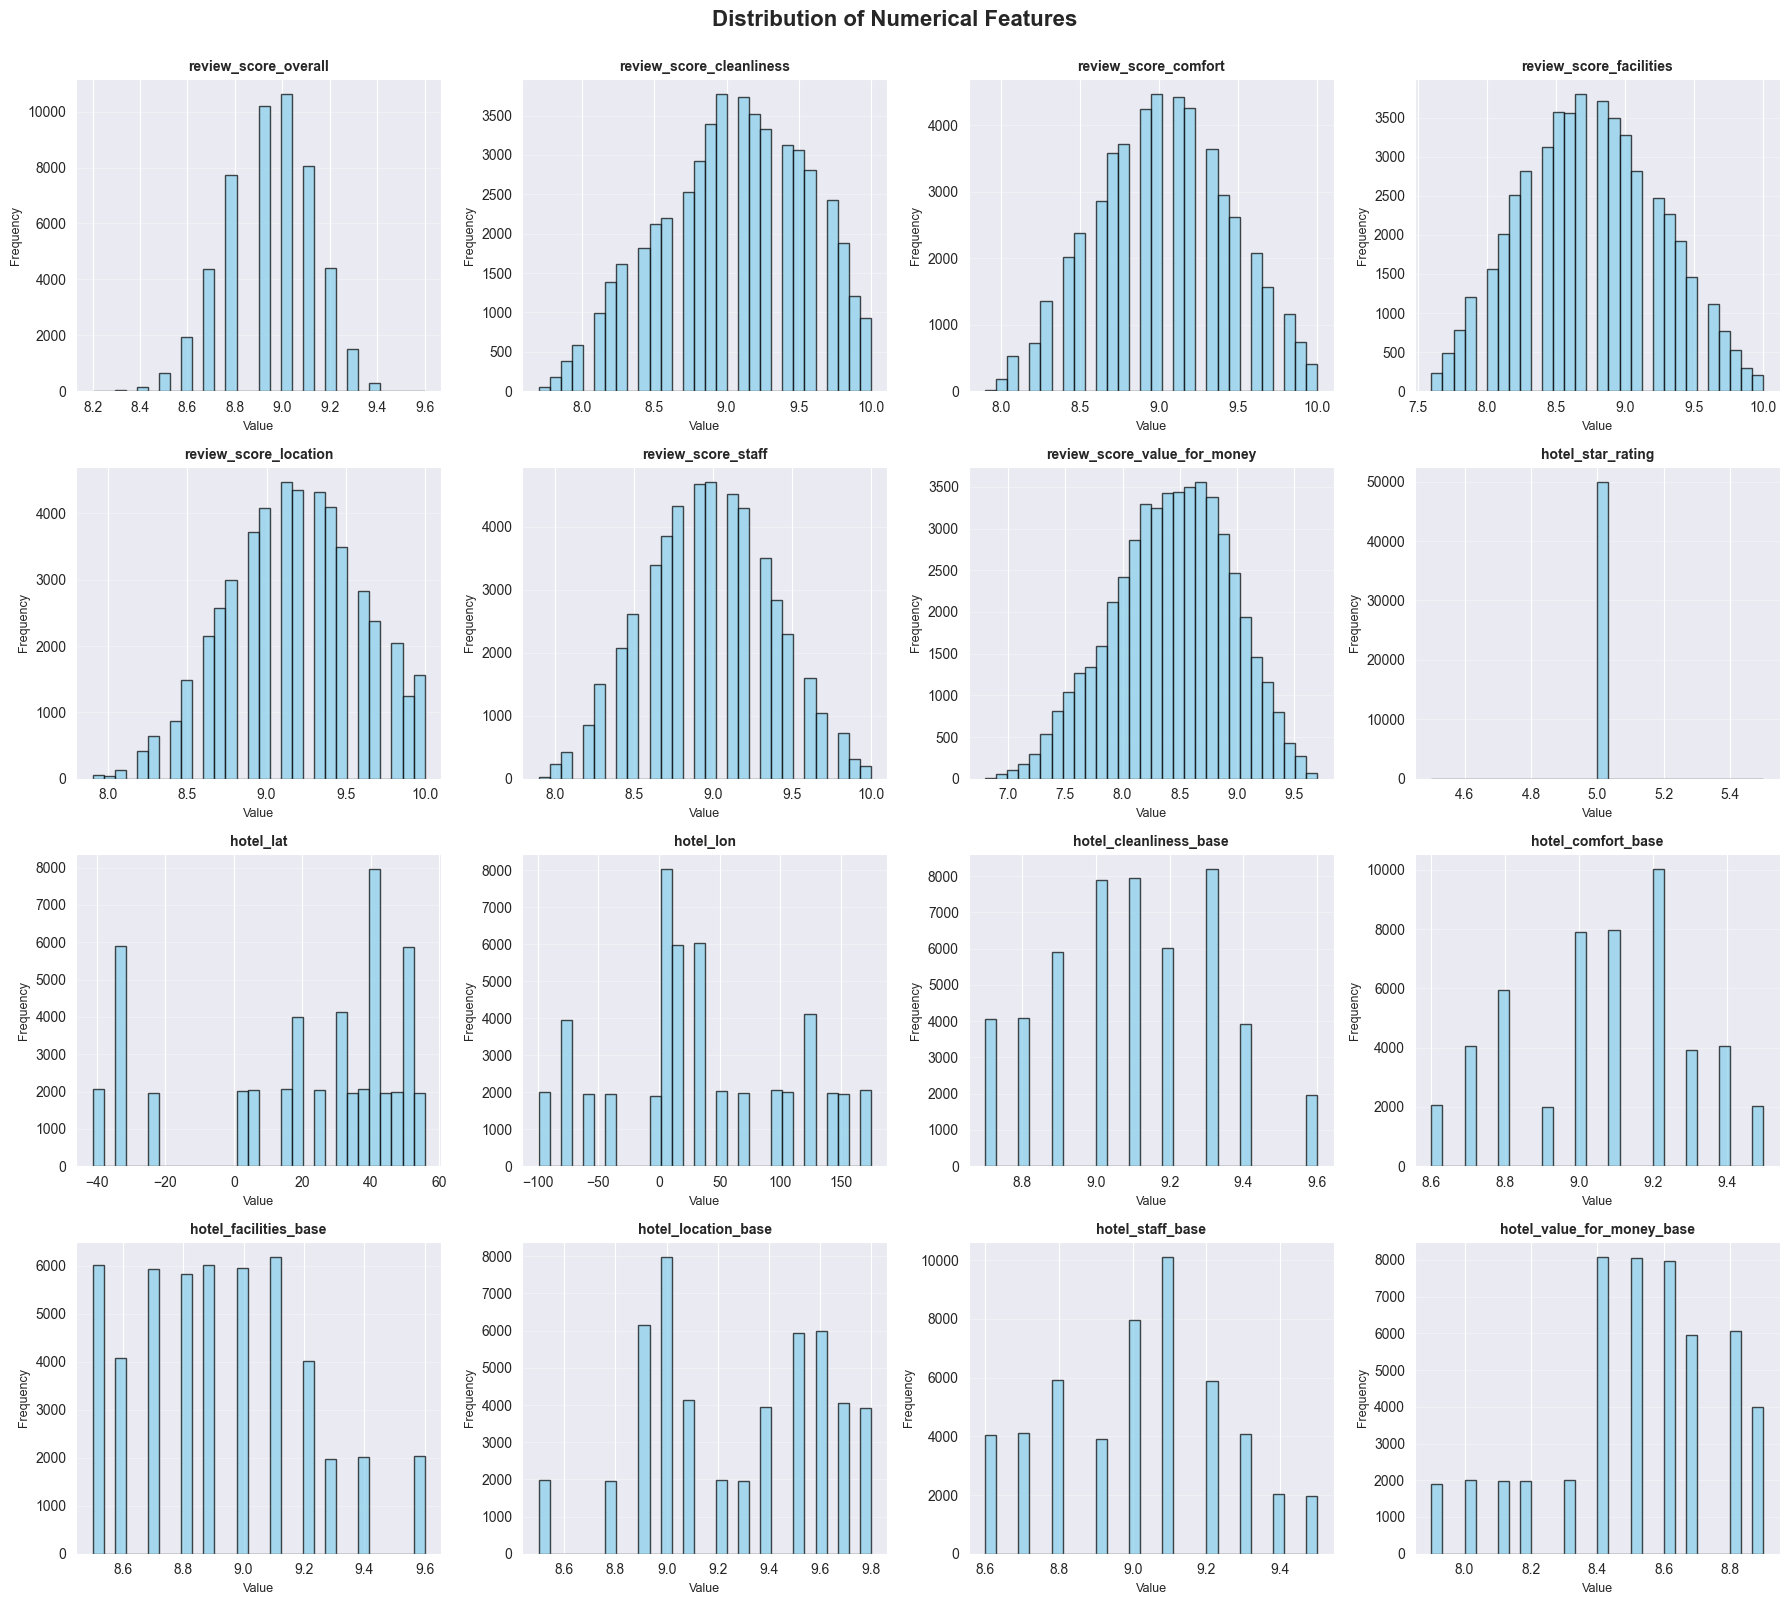

In [27]:
# Visualize the distribution of numerical features using histograms
# This helps us understand if features are normally distributed, skewed, etc.

fig, axes = plt.subplots(4, 4, figsize=(18, 16))
axes = axes.ravel()  # Flatten the 2D array to 1D

# Plot histogram for each numerical column without ids
plot_idx = 0  # Separate counter for axes indexing
for idx, col in enumerate(numerical_cols[:19]):
    if col == 'review_id' or col == 'user_id' or col == 'hotel_id':
        continue
    axes[plot_idx].hist(df_merged[col], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    axes[plot_idx].set_title(f'{col}', fontsize=10, fontweight='bold')
    axes[plot_idx].set_xlabel('Value', fontsize=9)
    axes[plot_idx].set_ylabel('Frequency', fontsize=9)
    axes[plot_idx].grid(axis='y', alpha=0.3)   # alpha = transparency
    plot_idx += 1  # Increment only when we actually plot

plt.suptitle('Distribution of Numerical Features', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

In [ ]:
# Use box plots to detect outliers in numerical features
# Box plots show: median (center line), quartiles (box edges), and outliers (dots beyond whiskers)

fig, axes = plt.subplots(4, 4, figsize=(18, 16))
axes = axes.ravel()

plot_idx = 0  # Separate counter for axes indexing
# Create box plot for each numerical column
for idx, col in enumerate(numerical_cols[:19]):
    if col == 'review_id' or col == 'user_id' or col == 'hotel_id':
        continue
    axes[plot_idx].boxplot(df_merged[col], vert=True)
    axes[plot_idx].set_title(f'{col}', fontsize=10, fontweight='bold')
    axes[plot_idx].set_ylabel('Value', fontsize=9)
    axes[plot_idx].grid(axis='y', alpha=0.3)
    plot_idx += 1

plt.suptitle('Box Plots for Outlier Detection', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\n Insights:")
print("- The box represents the interquartile range (IQR): 25th to 75th percentile")
print("- The line inside the box is the median (50th percentile)")
print("- Whiskers extend to 1.5 * IQR from the box")
print("- Points beyond whiskers are potential outliers")

## 3.3 - Correlation Analysis

Correlation analysis helps us identify relationships between numerical features. High correlation can indicate:
- Redundant features (multicollinearity)
- Features that move together
- Potential feature combinations

In [ ]:
# Calculate correlation matrix (Pearson correlation coefficient)
# Values range from -1 (perfect negative correlation) to +1 (perfect positive correlation)

numerical_cols = [col for col in numerical_cols
                           if col not in ['review_id', 'user_id', 'hotel_id']]

correlation_matrix = df_merged[numerical_cols].corr()

# Visualize using a heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={'label': 'Correlation Coefficient'}
)
plt.title('Correlation Matrix Heatmap', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Find and print highly correlated pairs (correlation > 0.8 or < -0.8)
print("\n")
print("Highly Correlated Feature Pairs (|correlation| > 0.8):")
print("\n")
print(f"{'Feature 1':<35} {'Feature 2':<35} {'Correlation':>10}")
print("-"*80)

highly_correlated_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.8:
            feat1 = correlation_matrix.columns[i]
            feat2 = correlation_matrix.columns[j]
            print(f"{feat1:<35} {feat2:<35} {corr_value:>10.3f}")
            highly_correlated_pairs.append((feat1, feat2, corr_value))


## 3.4 - Categorical Features Analysis

Let's examine the distribution of categorical features to understand user demographics and traveller characteristics.

In [ ]:
# Define categorical features to analyze
categorical_features = ['user_gender', 'user_age_group', 'user_traveller_type','user_country']

print("CATEGORICAL FEATURES DISTRIBUTION")

for feat in categorical_features:
    print(f"\n{feat.upper().replace('_', ' ')}:")
    print("-" * 40)
    counts = df_merged[feat].value_counts()

    # Display counts and percentages
    for value, count in counts.items():
        percentage = (count / len(df_merged)) * 100
        print(f"  {value:<30} {count:>6} ({percentage:>5.2f}%)")

    print(f"\n  Total unique values: {df_merged[feat].nunique()}")
    print("="*80)

In [ ]:
# Visualize categorical features using bar charts
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
axes = axes.ravel()

# Create a bar chart for each categorical feature
for idx, col in enumerate(categorical_features):
    # Get value counts and plot
    value_counts = df_merged[col].value_counts()
    value_counts.plot(kind='bar', ax=axes[idx], color='teal', alpha=0.7, edgecolor='black')

    # Formatting
    axes[idx].set_title(f'{col.replace("_", " ").title()} Distribution',
                        fontsize=13, fontweight='bold')
    axes[idx].set_xlabel(col.replace('_', ' ').title(), fontsize=11)
    axes[idx].set_ylabel('Count', fontsize=11)
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(axis='y', alpha=0.3)

    # Add value labels on top of bars
    for container in axes[idx].containers:
        axes[idx].bar_label(container, fmt='%d', padding=3, fontsize=9)

plt.suptitle('Distribution of Categorical Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

---

## 3.5 - EDA Summary & Key Insights

Based on the exploratory data analysis, here are the key findings:

### Target Variable (country_group)
 **Class imbalance**: The dataset shows a moderate class imbalance with a 6:1 ratio between largest and smallest country groups.
- *Largest class*: Western Europe (most reviews).
- *Smallest class*: Eastern Europe (fewest reviews).

This imbalance indicates the need for *stratified sampling* during the train/test split to ensure all regions are properly represented in the model.

### Data Leakage
The features *hotel_city* and *hotel_country* and *all base line scores of hotels* would allow the model to “cheat” by inferring the target from already-known information rather than learning genuine patterns [Since there are 25 unique hotels].

###  Numerical Features
**Scale**: Most numerical features (review and baseline scores) are on a 0–10 scale.

**Distribution**: They are roughly normally distributed with slight right skew (most hotels receive fairly high ratings).

**Outliers**: Only a few mild outliers were detected in the box plots.

**Variance**: Features show reasonable variance, which is helpful for modeling

###  Feature Correlations
**Review scores**: Highly correlated with each other (users who rate one aspect highly tend to rate others highly too).

**Hotel baseline scores**: Show moderate correlation.

###  Categorical Features

**User Gender:**
- Fairly balanced distribution across Male/Female/Other.
- No major gender bias in the dataset.

**User Age Group:**
- Most users fall in the 25-44 age range
- Represents the primary demographic for hotel reviews.

**Traveller Type:**
- *Couples* and *Families* are the most common (make up about ~60% of reviews).

- *Business* and *Solo* travelers are less common but still well-represented.



---

# Section 4: Feature Engineering

**Objective:** Create deviation features to capture how individual user experiences differ from hotel baselines.

**Approach:** We will use user demographics and deviation features to predict country groups.

## 4.1 - Deviation Features

**Justification:** Deviation features capture how individual user experiences differ from hotel baselines.

**Formula:** deviation = individual_review_score - hotel_baseline_score

This indicates:
- Whether the user's experience was better or worse than the hotel's average
- How user satisfaction compares to typical hotel performance
- Individual user preferences relative to hotel standards

### Computing the Deviation

In [ ]:
# Formula: deviation = individual_review_score - hotel_baseline_score

df_merged['deviation_cleanliness'] = (
    df_merged['review_score_cleanliness'] - df_merged['hotel_cleanliness_base']
)

df_merged['deviation_comfort'] = (
    df_merged['review_score_comfort'] - df_merged['hotel_comfort_base']
)

df_merged['deviation_facilities'] = (
    df_merged['review_score_facilities'] - df_merged['hotel_facilities_base']
)

df_merged['deviation_location'] = (
    df_merged['review_score_location'] - df_merged['hotel_location_base']
)

df_merged['deviation_staff'] = (
    df_merged['review_score_staff'] - df_merged['hotel_staff_base']
)

df_merged['deviation_value_for_money'] = (
    df_merged['review_score_value_for_money'] - df_merged['hotel_value_for_money_base']
)

deviation_cols = [col for col in df_merged.columns if col.startswith('deviation_')]
print(df_merged[deviation_cols].head())

### Analysis

In [ ]:
df_merged[deviation_cols].describe()

---

# Section 5: Data Preprocessing

**Objective:** Prepare data to be ready for our machine learning model through encoding, scaling, and splitting.

**Selected Features:**
- Categorical: *user_gender*, *user_age_group*, *user_traveller_type* (user demoghraphics)
- Numerical: score-based features and the new engineered features *deviation*
- Target: *country_group*

## 5.0 - Importing libraries

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

## 5.1 - Feature Selection

In [ ]:
df_processed = df_merged.copy()

selected_columns = [
    # Categorical features
    'user_gender', 'user_age_group', 'user_traveller_type',

    # Review scores (excluding overall)
    'review_score_cleanliness', 'review_score_comfort', 
    'review_score_facilities', 'review_score_location',
    'review_score_staff', 'review_score_value_for_money',

    # Deviation features
    'deviation_cleanliness', 'deviation_comfort',
    'deviation_facilities', 'deviation_location',
    'deviation_staff', 'deviation_value_for_money',
    
    # Target
    'country_group'
]

df_processed = df_processed[selected_columns]

## 5.2 - Encoding

**Objective**: Converting categorical features into numerical form.

*One-hot encoding:* used for unordered (nominal) features.

In [ ]:
df_processed = pd.get_dummies(
    df_processed, 
    columns=['user_gender', 'user_age_group', 'user_traveller_type'],
    drop_first=True
)

print("After encoding:")
print(f"\nColumn names:")
print(df_processed.columns.tolist())

## 5.3 - Split Features and Target

In [ ]:
X = df_processed.drop('country_group', axis=1)
y = df_processed['country_group']

## 5.4 - Train-Test-Validation Split

Split the data into 70% training, 15% validation, and 15% test sets using stratified sampling.

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# split 30% into 15% val and 15% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print("Dataset Split:")
print(f"Train: {X_train.shape}")
print(f"Val:   {X_val.shape}")
print(f"Test:  {X_test.shape}")

## 5.5 - Encode Target Variable

Convert country_group labels to numerical format using LabelEncoder.

In [ ]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

print("Class Mapping:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"{i}: {class_name}")

---

# Section 6: Model Development

**Objective:** Train and compare classification models to predict country groups.

We will train 2 different models:
1. Logistic Regression (baseline linear model)
2. Random Forest (ensemble tree-based)

## 6.1 - Import Required Libraries

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

print("Libraries imported successfully!")

## 6.2 - Model 1: Logistic Regression

A linear model that serves as our baseline. Uses one-vs-rest strategy for multi-class classification.

In [ ]:
print("Training Logistic Regression...")

# Initialize with class_weight to handle imbalance
lr_model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Train on training set
lr_model.fit(X_train, y_train)

# Predict on validation set
y_val_pred_lr = lr_model.predict(X_val)

# Calculate accuracy
lr_accuracy = accuracy_score(y_val, y_val_pred_lr)

print(f"Logistic Regression Validation Accuracy: {lr_accuracy:.4f} ({lr_accuracy*100:.2f}%)")
print("Model trained successfully!")

## 6.3 - Model 2: Random Forest

An ensemble of decision trees that votes on the final prediction. Good at capturing non-linear patterns.

In [ ]:
print("Training Random Forest...")

# Initialize with balanced class weights
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Train on training set
rf_model.fit(X_train, y_train)

# Predict on validation set
y_val_pred_rf = rf_model.predict(X_val)

# Calculate accuracy
rf_accuracy = accuracy_score(y_val, y_val_pred_rf)

print(f"Random Forest Validation Accuracy: {rf_accuracy:.4f} ({rf_accuracy*100:.2f}%)")
print("Model trained successfully!")

## 6.4 - Model Comparison

Compare both models on validation set to identify the best performer.

In [ ]:
import results

In [ ]:
# Create comparison dataframe
results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest"],
    "Validation Accuracy": [lr_accuracy, rf_accuracy],
    "Type": ["Linear", "Tree Ensemble"]
})

# Sort by accuracy
results = results.sort_values("Validation Accuracy", ascending=False)

print("="*70)
print("MODEL COMPARISON - VALIDATION SET")
print("="*70)
print(results.to_string(index=False))
print("="*70)

# Visualize comparison
plt.figure(figsize=(8, 6))
bars = plt.bar(results["Model"], results["Validation Accuracy"], 
               color=["#3498db", "#2ecc71"])

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f"{height:.2%}",
             ha="center", va="bottom", fontweight="bold")

plt.xlabel("Model", fontsize=12)
plt.ylabel("Validation Accuracy", fontsize=12)
plt.title("Model Performance Comparison", fontsize=14, fontweight="bold")
plt.xticks(rotation=0)
plt.ylim(0, max(results["Validation Accuracy"]) * 1.15)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# Identify best model
best_model_name = results.iloc[0]["Model"]
best_accuracy = results.iloc[0]["Validation Accuracy"]

print(f"Best Model: {best_model_name}")
print(f"Best Validation Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")

---

# Section 7: Model Evaluation

**Objective:** Evaluate both models on the test set using comprehensive metrics including accuracy, precision, recall, and F1-score.

## 7.1 - Test Set Evaluation

Evaluate both Logistic Regression and Random Forest models on the held-out test set.

In [ ]:
import model

In [ ]:
# Evaluate both models on test set
models = {
    "Logistic Regression": lr_model,
    "Random Forest": rf_model
}

results = []
for name, model in models.items():
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average="weighted", zero_division=0),
        "Recall": recall_score(y_test, y_pred, average="weighted", zero_division=0),
        "F1-Score": f1_score(y_test, y_pred, average="weighted", zero_division=0)
    })

# Create results dataframe
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("Accuracy", ascending=False)

print("="*80)
print("MODEL EVALUATION - TEST SET")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)

# Visualize metrics comparison
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(results_df))
width = 0.2

ax.bar(x - 1.5*width, results_df["Accuracy"], width, label="Accuracy", color="#3498db")
ax.bar(x - 0.5*width, results_df["Precision"], width, label="Precision", color="#2ecc71")
ax.bar(x + 0.5*width, results_df["Recall"], width, label="Recall", color="#e74c3c")
ax.bar(x + 1.5*width, results_df["F1-Score"], width, label="F1-Score", color="#f39c12")

ax.set_xlabel("Model", fontsize=12)
ax.set_ylabel("Score", fontsize=12)
ax.set_title("Model Performance Metrics Comparison (Test Set)", fontsize=14, fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels(results_df["Model"])
ax.legend()
ax.grid(axis="y", alpha=0.3)
ax.set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

## 7.2 - Confusion Matrix Analysis

Visualize the confusion matrices to understand where each model makes mistakes.

In [ ]:
# Create confusion matrices for both models
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, (name, model) in enumerate(models.items()):
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Get unique labels in sorted order
    labels = sorted(y_test.unique())
    
    # Plot heatmap
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[idx],
                xticklabels=labels, yticklabels=labels)
    axes[idx].set_title(f"{name}Confusion Matrix", fontsize=13, fontweight="bold")
    axes[idx].set_xlabel("Predicted Label", fontsize=11)
    axes[idx].set_ylabel("True Label", fontsize=11)
    axes[idx].tick_params(axis="x", rotation=45)
    axes[idx].tick_params(axis="y", rotation=0)

plt.tight_layout()
plt.show()

print("Confusion Matrix Insights:")
print("- Diagonal elements show correctly classified instances")
print("- Off-diagonal elements show misclassifications")
print("- Darker blue indicates higher counts")

## 7.3 - Detailed Classification Reports

Per-class performance metrics for each model.

In [ ]:
# Logistic Regression Classification Report
print("="*80)
print("LOGISTIC REGRESSION - CLASSIFICATION REPORT")
print("="*80)
y_pred_lr = lr_model.predict(X_test)
print(classification_report(y_test, y_pred_lr, zero_division=0))
print("="*80)

In [ ]:
# Random Forest Classification Report
print("="*80)
print("RANDOM FOREST - CLASSIFICATION REPORT")
print("="*80)
y_pred_rf = rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf, zero_division=0))
print("="*80)

## 7.4 - Evaluation Summary

**Key Findings:**

1. **Overall Performance:** Both models show comparable performance on the test set.

2. **Precision vs Recall Trade-off:** 
   - Precision indicates how many predicted instances of a class are actually correct
   - Recall indicates how many actual instances of a class were correctly identified

3. **F1-Score:** The harmonic mean of precision and recall, providing a balanced metric.

4. **Class Imbalance Impact:** Performance may vary across country groups due to the 6:1 imbalance ratio.

5. **Model Selection:** The model with higher F1-score on minority classes would be preferred for balanced performance.

---

# Section 8: Model Explainability (XAI)

**Objective:** Use SHAP and LIME to explain model predictions and identify important features.

## 8.1 - SHAP Analysis

TODO: Global and local explanations using SHAP

In [ ]:
# TODO: SHAP analysis
# import shap
#
# # Initialize explainer (use TreeExplainer for tree-based models)
# explainer = shap.TreeExplainer(best_model)
# shap_values = explainer.shap_values(X_test)
#
# # Global feature importance
# shap.summary_plot(shap_values, X_test)
# shap.summary_plot(shap_values, X_test, plot_type="bar")
#
# # Local explanations (pick 3-5 instances)
# for i in [0, 10, 50]:
#     shap.force_plot(explainer.expected_value, shap_values[i], X_test.iloc[i])
#     shap.waterfall_plot(shap.Explanation(values=shap_values[i],
#                                          base_values=explainer.expected_value,
#                                          data=X_test.iloc[i]))

## 8.2 - LIME Analysis

TODO: Local instance explanations using LIME

In [ ]:
# TODO: LIME analysis
# import lime
# import lime.lime_tabular
#
# # Initialize explainer
# explainer = lime.lime_tabular.LimeTabularExplainer(
#     X_train.values,
#     feature_names=X_train.columns,
#     class_names=['North_America', 'Western_Europe', ...],  # all 11 classes
#     mode='classification'
# )
#
# # Explain same instances as SHAP for comparison
# for idx in [0, 10, 50]:
#     exp = explainer.explain_instance(X_test.iloc[idx].values,
#                                       best_model.predict_proba)
#     exp.show_in_notebook()
#     exp.as_pyplot_figure()

---

# Section 9: Inference Function

**Objective:** Create a deployable function that accepts raw input and returns predictions in natural language.

TODO: Build inference function that preprocesses input and returns human-readable predictions

In [ ]:
# TODO: Create inference function
# def predict_country_group(user_gender, user_age_group, user_traveller_type,
#                           user_country, review_score_overall,
#                           review_score_cleanliness, review_score_comfort,
#                           review_score_facilities, review_score_location,
#                           review_score_staff, review_score_value_for_money,
#                           hotel_cleanliness_base, hotel_comfort_base,
#                           hotel_facilities_base, hotel_location_base,
#                           hotel_staff_base, hotel_value_for_money_base):
#     """
#     Predicts the country group of a hotel based on user and hotel features.
#
#     Returns:
#         str: Predicted country group in natural language
#     """
#
#     # 1. Create input dataframe
#     input_data = pd.DataFrame({
#         'user_gender': [user_gender],
#         'user_age_group': [user_age_group],
#         # ... add all features
#     })
#
#     # 2. Apply same preprocessing (encoding, scaling, feature engineering)
#     # ... your preprocessing code here
#
#     # 3. Make prediction
#     prediction = best_model.predict(processed_input)[0]
#
#     # 4. Convert to natural language
#     country_group_map = {
#         'North_America': 'North America (United States, Canada)',
#         'Western_Europe': 'Western Europe (Germany, France, UK, Netherlands, Spain, Italy)',
#         # ... rest of mappings
#     }
#
#     return country_group_map[prediction]
#
# # Test with examples
# example_1 = predict_country_group(
#     user_gender='Male',
#     user_age_group='25-34',
#     user_traveller_type='Business',
#     # ... provide all parameters
# )
# print(f"Prediction: {example_1}")